# <span style="color:rgb(75,104,184)">Évaluation d'un apprentissage et méthodes d'optimisation</span>

# <span style="color:rgb(75,104,184)">Méthodes d'optimisation</span>


# <span style="color:rgb(75,104,184)">TP1 - Optimisation avec la méthode de gradient</span>


Les librairies NumPy et SciPy seront utilisées durant la séance du TP.

- Ce notebook du cours, qui mêlent code en Python et blocs de texte et Latex. Dans un terminal, lancer la commande "jupyter notebook". Puis charger le fichier TP1-SCPAD.ipynb

- Les différents blocs sont faits pour être exécutés les uns à la suite des autres. On prendra notamment soin d'exécuter le premier bloc ci-dessous pour disposer de toutes les fonctions utiles.

Quelques fonctions utiles NumPy :

* *np.ones((m,n))* matrice de taille m x n avec composantes égales à 1. 
* *np.zeros((m,n))* matrice de taille m x n avec composantes égales à 0.
* *np.identity(n)* matrice identité de taille n x n.
* *np.pi* $\pi$.
* *np.inf* nombre infini en mémoire.
* *np.arange* permet de créer un tableau d'éléments numériques de manière itérative, en spécifiant un début, une fin et un pas.
* *np.log* logarithme appliqué à chaque coordonnée des tableaux NumPy.
* *np.exp* exponentielle appliquée à chaque coordonnée des tableaux NumPy.
* *np.sum* somme des composantes d'un tableau NumPy (pour les matrices, somme selon une dimension)
* *np.maximum(u,v)* renvoie un tableau NumPy array dont les composantes sont $max(u_i,v_i)$, si $u_i$ et $v_i$ sont celles de $u$ et $v$.
* *np.concatenate* concatène des tableaux NumPy (vecteurs, matrices) de dimensions compatibles.
* Si t est un tableau NumPy, la fonction *t.shape* renvoie les dimension(s) de ce tableau (utile lorsque l'on cherche à définir un tableau avec les mêmes dimensions.)
* *np.random.randn(d)* est une fonction qui génère des nombres aléatoires en utilisant une distribution normale standard.
* *np.linalg.pinv(X)* est une fonction qui calcule la pseudo-inverse d'une matrice. La pseudo-inverse est une généralisation de l'inverse d'une matrice qui est définie pour toutes les matrices, même celles qui ne sont pas inversibles.

# Imports des bibliothèques et fonctions utiles

In [3]:
# Génération des graphiques avec matplotlib
import matplotlib.pyplot as plt
from math import sqrt # Racine carrée

In [4]:
import sys
# NumPy : propose des structures et fonctions vectorielles et matricielles
import numpy as np # Bibliothèque NumPy
from numpy.random import randn # distributions de probabilité : multivariate_normal pour simu_linreg

# SciPy - Calculs mathématiques efficaces
from scipy.linalg import norm # normes classiques (à utiliser pour implémenter le TP)
from scipy.linalg import toeplitz # matrices de Toeplitz pour simu_linreg
from scipy.optimize import check_grad # vérification des dérivées

# <span style="color:rgb(75,104,184)">Introduction</span>

Le but de cette séance est d'illustrer la performance de la descente de gradient sur des problèmes d'optimisation non linéaire classiques. On commence pour cela par considérer les problèmes aux moindres carrés non linéaire.

# <span style="color:rgb(75,104,184)">Moindres carrés</span>

## <span style="color:rgb(75,104,184)">1.1 Jeu de données</span>

Soit un jeu de données $\{(\mathbf{x}_i,y_i)\}_{i=1,\dots,n}$, où $\mathbf{x}_i \in \mathbb{R}^d$ et $y_i \in \mathbb{R}$, que l'on met sous la forme

- d'une matrice de caractéristiques (features) $\mathbf{X} \in \mathbb{R}^{n \times d}$;
- et d'un vecteur de labels $\mathbf{y} \in \mathbb{R}^n$. 

Nous considérons un jeu de données jouet d'un problème de regression, les données suivent une tendance linéaire à laquelle on rajoutera un bruit gaussien.



In [8]:
# les données qui correspondent aux caratéristiques sont dans la variable X et les labels sont dans la variable y

X = np.genfromtxt('instances.csv', delimiter=';')
y = np.genfromtxt('labels.csv', delimiter=';')

d = X.shape[1] # number of features (dimension)
n = X.shape[0] # number of instances (observations)
idx = np.arange(d)

print(d,n)

print(X)
print(y)




50 1000
[[-2.00972073  2.48707005  1.04725899 ... -0.92495087 -1.00195358
  -1.88182411]
 [-0.60653243  1.14528494 -1.16511618 ... -0.72445859 -0.21054433
   0.63924509]
 [-1.6777934   1.44962286 -0.12309153 ...  0.41306675  0.41126912
  -0.1102292 ]
 ...
 [ 0.1226661   0.32815609 -0.89819398 ...  0.11195291  1.12799531
   1.14529935]
 [ 0.08643173  0.67494546 -0.24765788 ... -0.0187576  -1.55791603
   0.59832912]
 [ 1.27707334  0.61956562  0.40763101 ...  0.29345988 -0.39217341
   1.11067336]]
[-4.54368112e+00 -2.08702174e+00 -4.83839640e+00 -1.51435759e+00
 -1.52902838e+00 -1.65869259e+00 -1.38979516e-01 -1.40030324e+00
  1.05027732e+00 -1.40815926e-01  1.16359962e+00  1.11733798e+00
  3.10613800e+00  3.74529314e-01  1.86733997e+00 -2.53211896e+00
 -7.54056908e-01 -1.64745161e+00 -3.06704076e+00 -1.88834665e+00
  6.42438208e-01  1.19323373e+00 -4.78929949e+00 -1.62328234e+00
 -1.15312828e+00 -1.92269376e+00  1.89402613e+00  1.15931259e+00
 -1.29093731e+00  5.81924496e-01  7.12196397e

## <span style="color:rgb(75,104,184)">1.2 Problème de regression linéaire</span>

Notre objectif est de construire un modèle linéaire qui colle au plus près à nos données afin d'avoir des prédiction pertinentes sur de nouvelles données autres les données présentes dans $\mathbf{X}$. 

Partant de $(\mathbf{X},\mathbf{y})$, on cherche ainsi $\mathbf{w} \in \mathbb{R}^d$ tel que $\mathbf{X} \mathbf{w} -\mathbf{y} \approx 0$.

Sans a priori sur la nature du bruit dont les observations sont entachées (ou en supposant que ce bruit est gaussien), on peut formuler notre objectif comme un problème aux moindres carrés :
$$
    \mbox{minimiser}_{\mathbf{w} \in \mathbb{R}^d} 
    f(\mathbf{w}) := \frac{1}{2 n} \|\mathbf{X} \mathbf{w} - \mathbf{y}\|^2 
    = \frac{1}{2n} \sum_{i=1}^n (\mathbf{x}_i^T \mathbf{w} - y_i)^2.
$$


Le problème peut se réécrire comme un *problème d'optimisation quadratique* de la forme :
$$
    \mbox{minimiser}_{\mathbf{w} \in \mathbb{R}^d} \frac{1}{2}\mathbf{w}^T \mathbf{A} \mathbf{w} - \mathbf{b}^T \mathbf{w} + c.
$$
avec $\mathbf{A} = \tfrac{\mathbf{X}^T \mathbf{X}}{n}$, $\mathbf{b} = \frac{\mathbf{X}^T \mathbf{y}}{n}$ et $c=\frac{\mathbf{y}^T \mathbf{y}}{2 n}$. 

On a ainsi $f(\mathbf{w})=\frac{1}{2}\mathbf{w}^T \mathbf{A} \mathbf{w} - \mathbf{b}^T \mathbf{w} + c$ pour tout $\mathbf{w} \in \mathbb{R}^d$. 

Cette fonction est de classe $\mathcal{C}^1$ (car polynomiale en chacune des variables), et son gradient est donné par
$$
    \nabla f(\mathbf{w}) 
    = \mathbf{A} \mathbf{w} - \mathbf{b} 
    = \frac{1}{n}\mathbf{X}^T \left(  \mathbf{X} \mathbf{w} - \mathbf{y}\right).
$$

La constante de Lipschitz est souvent utilisée pour évaluer la convergence d'un algorithme d'optimisation. En effet, si la fonction à optimiser a une constante de Lipschitz L faible, cela signifie que la fonction varie lentement et de manière régulière, ce qui facilite la recherche du minimum global. En revanche, si la constante de Lipschitz est élevée, cela signifie que la fonction varie rapidement et de manière chaotique, ce qui peut rendre la recherche du minimum global plus difficile et plus lente.

Le calcul de cette constante est donné dans la fonction lipgrad() ci-dessous afin de définir des stratégies de recherche pour la decente gradient. La fonction objectif à minimiser vérifie ces propriétés, pour l'instant nous n'abordons pas les propriétés théoriques.

In [17]:
# Classe Python pour les problèmes de régression linéaire
class LinReg(object):
    '''
        Problèmes de régression linéaire sous forme de moindres carrés linéaires.
        
        Attributs:
            X: Tableau à deux dimensions, matrice de données (caractéristiques)
            y: Tableau à une dimension, vecteur de données (labels/mesures/...)
            n,d: Dimensions du problème (X de taille n x d, y est de taille n)
            
        Méthodes:
            fun: Calcule la valeur de la fonction objectif pour les moindres carrés linéaires.
            grad: Calcule la valeur du gradient pour les moindres carrés linéaires.
            lipgrad: Calcule la valeur de la constante de Lipschitz pour le gradient.
    '''     

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
    
    # Fonction objectif
    def fun(self, w):
        ## COMPLETER LE CODE AVEC LA FORMULE DE LA FONCTION OBJECTIF
        return (1/(2 * self.n)) * norm(X.dot(w) - y)**2
    
    # Gradient
    def grad(self, w):
        ## COMPLETER LE CODE AVEC LA FORMULE DU GRADIENT
        return (1/n) * X.T.dot((X.dot(w)-y))

    # Constante de Lipschitz pour le gradient
    def lipgrad(self):
        L = norm(self.X, ord=2) ** 2 / self.n # Calcul plus économe de ||X^T X||
        return L 

## COMPLETER LE CODE AVEC L'INITIALIZATION DE LA CLASSE LinReg
# Génération de l'instance correspondante en utilisant la classe précédente
pblinreg = LinReg(X ,y)

# Vérification des formules que vous avez implémenté, et de la cohérence entre la fonction et le gradient
# important pour que l'algorithme fonctionne correctement
# Si le code vous renvoie une valeur de l'ordre de 10^(-6), 
# ça veut dire que vous êtes a priori bon, sinon revérifier l'implémention de fun et grad
check_grad(pblinreg.fun, pblinreg.grad, np.random.randn(d))
    

1.312761555802868e-06

## <span style="color:rgb(75,104,184)">1.2 Descente de gradient</span>

L'algorithme de descente de gradient appliqué à une fonction $f$ est défini par un point initial $w_0$ ainsi que 
par l'itération
$$
\mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \nabla f(\mathbf{w}_k),
$$
où $\alpha_k>0$ est une longueur de pas pour l'itération $k$.


*Compléter le squelette ci-dessous pour implémenter la descente de gradient avec trois choix de longueurs de pas possibles:*

- $\alpha_k = 0.025  $;
  
- $\alpha_k = \frac{\alpha_0}{k+1}$;

- $\alpha_k = \frac{\alpha_0}{\sqrt{k+1}}$;

- $\alpha_k = \frac{1}{L}$, *avec $L$ la constante de Lipschitz pour $\nabla f$;* 

*Valider ensuite l'implémentation en exécutant le script qui suit.*

In [23]:
# Descente de gradient
def grad_desc(w0,problem, strategy=0,step0=1, n_iter=1000, verbose=False): 
    """
        Un code pour la descente de gradient sur problèmes structurés avec différents choix de 
        longueurs de pas.
        
        Entrées:
            w0: Vecteur initial
            problem: Structure représentant le problème
                problem.fun(w) Fonction objectif
                problem.grad(w) Gradient
                problem.lipgrad() Constante de Lipschitz du gradient
            strategy: Stratégie pour la longueur de pas (see above)
                
                  
            step0: Longueur de pas initial (utile pour la strategie décroissante)
            n_iter: Nombre maximum d'itérations
            verbose: Booléen réglant l'affichage des informations à chaque itération
      
        Sorties:
            w_output: Les poids améliorés dans l'itéré final de la méthode
            objvals: Historique des valeurs de fonctions (tableau Numpy de taille n_iter) pour voir graphiquement l'évolution  de la fonction objectif
            ngvals: Historique des normes de gradient (tableau Numpy de taille n_iter) pour voir graphiquement la convergence de la strategie
            
    """
    
    ############
    # Initialisation

    # Historique des valeurs
    objvals = []
    # Normes de gradient
    ngvals = []
    
    # Constante de Lipschitz
    L = problem.lipgrad()
    # Valeur initiale de l'itéré courant   
    w = w0.copy()

    # Initialisation du compteur d'itérations
    k=0    
    
    # Fonction objectif en le point courant
    ## COMPLETER LE CODE AVEC LE CALCUL DE LA FONCTION OBJECTIF EN POINT INITIAL (POIDS INITIAUX) 
    
    obj = problem.fun(w0)
    
    # Gradient en le point initial
    ## COMPLETER LE CODE AVEC LE CALCUL DU GRADIENT EN POINT INITIAL

    g = problem.grad(w0)
    
    # on garde une trace de la fonction objectif et la norme gradient pendant la recherche 
    objvals.append(obj);
    ng = norm(g)
    ngvals.append(ng)

    # Affichage des valeurs initiales 
    if verbose:
        print("Descente de gradient :")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "ngrad"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ng).rjust(8)]))
    
    ####################
    # Boucle principale
    while (k < n_iter):
        
        # A COMPLETER AVEC LES DIFFÉRENTES STRATÉGIES CITÉES
        # Choisir la longueur de pas et mettre à jour l'itéré
        if strategy==0:
            # Longueur de pas constante
            w[:] = w - (step0 * g)
        elif strategy==1:
            # Longueur de pas decroissante
            w[:] = w - ((step0/(k+1)) * g)
        elif strategy==2:
            # Longueur de pas decroissante a_0/(k+1)
            w[:] = w - ((step0/np.sqrt(k+1)) * g)
        elif strategy==3:
            # Longueur de pas 
            w[:] = w - (1/L * g)
        else:
            print("no strategy was selected for the gradient")
            sys.exit(1)
        
        # FIN A COMPLETER
        
        
        # A COMPLÉTER AVEC LE CALCUL DE NOUVELLES INFORMATION EN POINT COURANT

        obj = problem.fun(w)
        g = problem.grad(w)

        # on garde une trace de la fonction objectif et la norme gradient pendant la recherche 
        objvals.append(obj)
        ng = norm(g)
        ngvals.append(ng)
        
        # Affichage si demandé
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ng).rjust(8)]))       
        
        # A COMPLÉTER POUVOIR PASSER À L'ITÉRATION SUIVANTE
        k += 1
    
    # Fin boucle principale
    ######################
    
    # Informations de sortie
    w_output = w.copy()
    return w_output, np.array(objvals), np.array(ngvals)

*Valider ensuite l'implémentation en exécutant le script qui suit.*

In [37]:
# Tester quatre variantes de descente de gradient
w0 = np.zeros(d)
w_a, obj_a, ngrad_a = grad_desc(w0,pblinreg, strategy=0,step0=1/1.59, n_iter=100, verbose=False)
w_b, obj_b, ngrad_b = grad_desc(w0,pblinreg, strategy=1,step0=1, n_iter=100, verbose=False)
w_c, obj_c, ngrad_c = grad_desc(w0,pblinreg, strategy=2,step0=1, n_iter=100, verbose=False)
w_d, obj_d, ngrad_d = grad_desc(w0,pblinreg, strategy=3,step0=1, n_iter=100, verbose=False)


# Comparaison de trois variantes de descente de gradient 

# Affichage des meilleures valeurs obtenues
print("Fonction objectif finale pour GD - 0.025",obj_b[-1])
print("Fonction objectif finale pour GD - 1/(k+1)",obj_b[-1])
print("Fonction objectif finale pour GD - 1/(sqrt(k+1))",obj_c[-1])
print("Fonction objectif finale pour GD - 1/L",obj_a[-1])

print(pblinreg.lipgrad())

Fonction objectif finale pour GD - 0.025 0.4739023566065613
Fonction objectif finale pour GD - 1/(k+1) 0.4739023566065613
Fonction objectif finale pour GD - 1/(sqrt(k+1)) 0.4733956184434164
Fonction objectif finale pour GD - 1/L 0.47339561843205535
1.5915710856419105


-- On pourra afficher l'évolution des valeurs de fonction relativement à la vraie valeur à l'optimum vmin

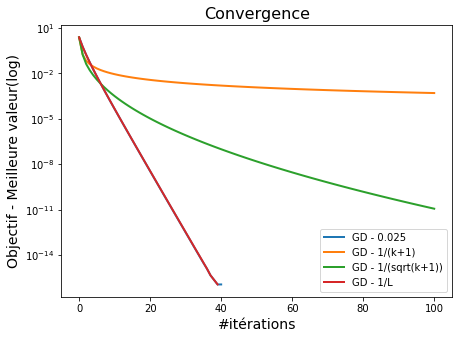

In [38]:
# Note : en échelle logarithmique, les valeurs f(w)-vmin très proches de 0 ne s'affichent pas
# on calcule le vmin sur la formule originale des moindres carrés 
vmin = (1/(2*n))*(norm(X.dot(np.linalg.pinv(X).dot(y))-y)**2)
# Pour ne pas afficher d'écart relatif, on prendra vmin égal à 0 (le minorant de la question 1)
# vmin = 0

# En termes de fonction objectif 
plt.figure(figsize=(7, 5))
plt.semilogy(np.trim_zeros(obj_a-vmin), label="GD - 0.025", lw=2)
plt.semilogy(np.trim_zeros(obj_b-vmin), label="GD - 1/(k+1)", lw=2)
plt.semilogy(np.trim_zeros(obj_c-vmin), label="GD - 1/(sqrt(k+1))", lw=2)
plt.semilogy(np.trim_zeros(obj_d-vmin), label="GD - 1/L", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#itérations", fontsize=14)
plt.ylabel("Objectif - Meilleure valeur(log)", fontsize=14)
plt.legend()
plt.savefig('foo.pdf')

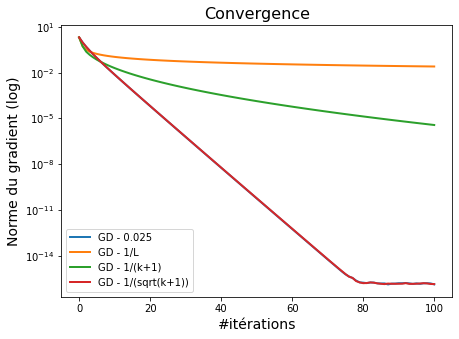

In [39]:
# En termes de norme de gradient
plt.figure(figsize=(7, 5))
plt.semilogy(ngrad_a, label="GD - 0.025", lw=2)
plt.semilogy(ngrad_b, label="GD - 1/L", lw=2)
plt.semilogy(ngrad_c , label="GD - 1/(k+1)", lw=2)
plt.semilogy(ngrad_d, label="GD - 1/(sqrt(k+1))", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#itérations", fontsize=14)
plt.ylabel("Norme du gradient (log)", fontsize=14)
plt.legend()